# 2024 RSNA Lumbar Spine Degeneration Classification

* First Notebook Initial EDA
* Look at file structures
* Simple submission first to make sure format is right

## Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pydicom as dicom

## Data Contents

* There are 5 csv files
    * train.csv
    * train_label_coordinates.csv
    * train_series_descriptions.csv
    * test_series_descriptions.csv
    * sample_submission.csv
* There are 1975 train images directories, each has multiple subdirectories with multiple .dcm files (18-40ish)


## Set Paths

In [2]:
# set the path to the training images directory
train_img_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/'


## Train File

In [3]:
train = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
print(train.shape)
train.head()

(1975, 26)


study_id spinal_canal_stenosis_l1_l2 spinal_canal_stenosis_l2_l3  \
0   4003253                 Normal/Mild                 Normal/Mild   
1   4646740                 Normal/Mild                 Normal/Mild   
2   7143189                 Normal/Mild                 Normal/Mild   
3   8785691                 Normal/Mild                 Normal/Mild   
4  10728036                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l3_l4 spinal_canal_stenosis_l4_l5  \
0                 Normal/Mild                 Normal/Mild   
1                    Moderate                      Severe   
2                 Normal/Mild                 Normal/Mild   
3                 Normal/Mild                 Normal/Mild   
4                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l5_s1 left_neural_foraminal_narrowing_l1_l2  \
0                 Normal/Mild                           Normal/Mild   
1                 Normal/Mild                           Normal/Mild   
2                 Normal/Mild                           Normal/Mild   
3                 Normal/Mild                           Normal/Mild   
4                 Normal/Mild                           Normal/Mild   

  left_neural_foraminal_narrowing_l2_l3 left_neural_foraminal_narrowing_l3_l4  \
0                           Normal/Mild                           Normal/Mild   
1                           Normal/Mild                           Normal/Mild   
2                           Normal/Mild                           Normal/Mild   
3                           Normal/Mild                           Normal/Mild   
4                           Normal/Mild                           Normal/Mild   

  left_neural_foraminal_narrowing_l4_l5  ... left_subarticular_stenosis_l1_l2  \
0                              Moderate  ...                      Normal/Mild   
1                              Moderate  ...                      Normal/Mild   
2                           Normal/Mild  ...                      Normal/Mild   
3                              Moderate  ...                      Normal/Mild   
4                           Normal/Mild  ...                      Normal/Mild   

  left_subarticular_stenosis_l2_l3 left_subarticular_stenosis_l3_l4  \
0                      Normal/Mild                      Normal/Mild   
1                      Normal/Mild                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   
3                      Normal/Mild                      Normal/Mild   
4                      Normal/Mild                      Normal/Mild   

  left_subarticular_stenosis_l4_l5 left_subarticular_stenosis_l5_s1  \
0                         Moderate                      Normal/Mild   
1                           Severe                      Normal/Mild   
2                      Normal/Mild                      Normal/Mild   
3                      Normal/Mild                      Normal/Mild   
4                      Normal/Mild                      Normal/Mild   

  right_subarticular_stenosis_l1_l2 right_subarticular_stenosis_l2_l3  \
0                       Normal/Mild                       Normal/Mild   
1                       Normal/Mild                          Moderate   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l3_l4 right_subarticular_stenosis_l4_l5  \
0                       Normal/Mild                       Normal/Mild   
1                          Moderate                          Moderate   
2                       Normal/Mild                       Normal/Mild   
3                       Normal/Mild                       Normal/Mild   
4                       Normal/Mild                          Moderate   

  right_subarticular_stenosis_l5_s1  
0                       Normal/Mild  


This file gives the study id, and severity classification for each subtype.
* There are 25 classification types to predict

In [4]:
class_types = [col for col in train.columns if 'study' not in col]
print('Classification types are:')
class_types

Classification types are:


['spinal_canal_stenosis_l1_l2',
 'spinal_canal_stenosis_l2_l3',
 'spinal_canal_stenosis_l3_l4',
 'spinal_canal_stenosis_l4_l5',
 'spinal_canal_stenosis_l5_s1',
 'left_neural_foraminal_narrowing_l1_l2',
 'left_neural_foraminal_narrowing_l2_l3',
 'left_neural_foraminal_narrowing_l3_l4',
 'left_neural_foraminal_narrowing_l4_l5',
 'left_neural_foraminal_narrowing_l5_s1',
 'right_neural_foraminal_narrowing_l1_l2',
 'right_neural_foraminal_narrowing_l2_l3',
 'right_neural_foraminal_narrowing_l3_l4',
 'right_neural_foraminal_narrowing_l4_l5',
 'right_neural_foraminal_narrowing_l5_s1',
 'left_subarticular_stenosis_l1_l2',
 'left_subarticular_stenosis_l2_l3',
 'left_subarticular_stenosis_l3_l4',
 'left_subarticular_stenosis_l4_l5',
 'left_subarticular_stenosis_l5_s1',
 'right_subarticular_stenosis_l1_l2',
 'right_subarticular_stenosis_l2_l3',
 'right_subarticular_stenosis_l3_l4',
 'right_subarticular_stenosis_l4_l5',
 'right_subarticular_stenosis_l5_s1']

Prediction types are 
* 'Normal/Mild'
* 'Moderate'
* 'Severe'

### Frequencies

In [5]:
probs = {}

# look at frequency of each classification type
for col in class_types:
    vals = train[col].value_counts().values
    tot = sum(vals)
    probs[col] = [vals[0]/tot,vals[1]/tot,vals[2]/tot]

probs[class_types[0]]

[0.955420466058764, 0.033941236068895646, 0.010638297872340425]

## Train Label Coords File

In [6]:
train_label_coords = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
print(f'Train label coords shape: {train_label_coords.shape}')
train_label_coords.loc[0:10]

Train label coords shape: (48692, 7)


study_id   series_id  instance_number                         condition  \
0    4003253   702807833                8             Spinal Canal Stenosis   
1    4003253   702807833                8             Spinal Canal Stenosis   
2    4003253   702807833                8             Spinal Canal Stenosis   
3    4003253   702807833                8             Spinal Canal Stenosis   
4    4003253   702807833                8             Spinal Canal Stenosis   
5    4003253  1054713880                4  Right Neural Foraminal Narrowing   
6    4003253  1054713880                4  Right Neural Foraminal Narrowing   
7    4003253  1054713880                5  Right Neural Foraminal Narrowing   
8    4003253  1054713880                6  Right Neural Foraminal Narrowing   
9    4003253  1054713880                6  Right Neural Foraminal Narrowing   
10   4003253  1054713880               11   Left Neural Foraminal Narrowing   

    level           x           y  
0   L1/L2  322.831858  227.964602  
1   L2/L3  320.571429  295.714286  
2   L3/L4  323.030303  371.818182  
3   L4/L5  335.292035  427.327434  
4   L5/S1  353.415929  483.964602  
5   L4/L5  187.961759  251.839388  
6   L5/S1  198.240918  285.613767  
7   L3/L4  187.227533  210.722753  
8   L1/L2  194.569790  127.755258  
9   L2/L3  191.632887  165.934990  
10  L1/L2  196.070671  126.021201

In [7]:
train_label_coords.level.value_counts()

level
L3/L4    9858
L4/L5    9858
L5/S1    9845
L2/L3    9661
L1/L2    9470
Name: count, dtype: int64

In [8]:
train[train.study_id == 4003253]

study_id spinal_canal_stenosis_l1_l2 spinal_canal_stenosis_l2_l3  \
0   4003253                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l3_l4 spinal_canal_stenosis_l4_l5  \
0                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l5_s1 left_neural_foraminal_narrowing_l1_l2  \
0                 Normal/Mild                           Normal/Mild   

  left_neural_foraminal_narrowing_l2_l3 left_neural_foraminal_narrowing_l3_l4  \
0                           Normal/Mild                           Normal/Mild   

  left_neural_foraminal_narrowing_l4_l5  ... left_subarticular_stenosis_l1_l2  \
0                              Moderate  ...                      Normal/Mild   

  left_subarticular_stenosis_l2_l3 left_subarticular_stenosis_l3_l4  \
0                      Normal/Mild                      Normal/Mild   

  left_subarticular_stenosis_l4_l5 left_subarticular_stenosis_l5_s1  \
0                         Moderate                      Normal/Mild   

  right_subarticular_stenosis_l1_l2 right_subarticular_stenosis_l2_l3  \
0                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l3_l4 right_subarticular_stenosis_l4_l5  \
0                       Normal/Mild                       Normal/Mild   

  right_subarticular_stenosis_l5_s1  
0                       Normal/Mild  

[1 rows x 26 columns]

In [9]:
# look at a single study
train_label_coords[train_label_coords.study_id == 4003253]

# there are 25, most likely one per classification type.  Verify this...

study_id   series_id  instance_number                         condition  \
0    4003253   702807833                8             Spinal Canal Stenosis   
1    4003253   702807833                8             Spinal Canal Stenosis   
2    4003253   702807833                8             Spinal Canal Stenosis   
3    4003253   702807833                8             Spinal Canal Stenosis   
4    4003253   702807833                8             Spinal Canal Stenosis   
5    4003253  1054713880                4  Right Neural Foraminal Narrowing   
6    4003253  1054713880                4  Right Neural Foraminal Narrowing   
7    4003253  1054713880                5  Right Neural Foraminal Narrowing   
8    4003253  1054713880                6  Right Neural Foraminal Narrowing   
9    4003253  1054713880                6  Right Neural Foraminal Narrowing   
10   4003253  1054713880               11   Left Neural Foraminal Narrowing   
11   4003253  1054713880               11   Left Neural Foraminal Narrowing   
12   4003253  1054713880               11   Left Neural Foraminal Narrowing   
13   4003253  1054713880               12   Left Neural Foraminal Narrowing   
14   4003253  1054713880               12   Left Neural Foraminal Narrowing   
15   4003253  2448190387                3        Left Subarticular Stenosis   
16   4003253  2448190387                4       Right Subarticular Stenosis   
17   4003253  2448190387               11        Left Subarticular Stenosis   
18   4003253  2448190387               11       Right Subarticular Stenosis   
19   4003253  2448190387               19        Left Subarticular Stenosis   
20   4003253  2448190387               19       Right Subarticular Stenosis   
21   4003253  2448190387               28        Left Subarticular Stenosis   
22   4003253  2448190387               28       Right Subarticular Stenosis   
23   4003253  2448190387               35        Left Subarticular Stenosis   
24   4003253  2448190387               35       Right Subarticular Stenosis   

    level           x           y  
0   L1/L2  322.831858  227.964602  
1   L2/L3  320.571429  295.714286  
2   L3/L4  323.030303  371.818182  
3   L4/L5  335.292035  427.327434  
4   L5/S1  353.415929  483.964602  
5   L4/L5  187.961759  251.839388  
6   L5/S1  198.240918  285.613767  
7   L3/L4  187.227533  210.722753  
8   L1/L2  194.569790  127.755258  
9   L2/L3  191.632887  165.934990  
10  L1/L2  196.070671  126.021201  
11  L4/L5  186.504472  251.592129  
12  L5/S1  197.100569  289.457306  
13  L2/L3  191.321555  170.120141  
14  L3/L4  187.878354  217.245081  
15  L1/L2  179.126448  161.235521  
16  L1/L2  145.288771  158.624642  
17  L2/L3  180.979730  158.764479  
18  L2/L3  145.900042  157.096466  
19  L3/L4  176.037645  157.528958  
20  L3/L4  142.843690  156.179561  
21  L4/L5  172.948842  156.911197  
22  L4/L5  147.428218  158.013372  
23  L5/S1  179.744208  161.853282  
24  L5/S1  145.900042  161.375358

This file gives the coordinates of the degeneration, and also the series id (subfolder), as well as the instance number which is the locatio of the individual dicom file in the 3d stack. Level is the relevant vertebrae

## Train Series Desc File

In [10]:
train_series_desc = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
train_series_desc.head(20)

study_id   series_id series_description
0    4003253   702807833   Sagittal T2/STIR
1    4003253  1054713880        Sagittal T1
2    4003253  2448190387           Axial T2
3    4646740  3201256954           Axial T2
4    4646740  3486248476        Sagittal T1
5    4646740  3666319702   Sagittal T2/STIR
6    7143189   132939515   Sagittal T2/STIR
7    7143189  1951927562           Axial T2
8    7143189  3219733239        Sagittal T1
9    8785691   481125819   Sagittal T2/STIR
10   8785691  1570286759        Sagittal T1
11   8785691  2406919186           Axial T2
12  10728036   142859125           Axial T2
13  10728036  2073726394           Axial T2
14  10728036  2399638375        Sagittal T1
15  10728036  3491739931   Sagittal T2/STIR
16  11340341  1224932122           Axial T2
17  11340341  2231042680        Sagittal T1
18  11340341  3543553307   Sagittal T2/STIR
19  11943292   403244853           Axial T2

In [11]:
# is this the same number of folders in train images?  It should be.
print(f'Length of train series desc: {train_series_desc.shape}')

Length of train series desc: (6294, 3)


Gives the orientation  and T1/T2 type of each study/series id
* Maybe separate classifiers for each orientation (this is something we will know for the test data).

## Test Description

In [12]:
test_desc = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')
test_desc.head()

study_id   series_id series_description
0  44036939  2828203845        Sagittal T1
1  44036939  3481971518           Axial T2
2  44036939  3844393089   Sagittal T2/STIR

## Sample Submission Format

In [13]:
ss = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')
ss.head()

row_id  normal_mild  moderate  \
0  44036939_left_neural_foraminal_narrowing_l1_l2     0.333333  0.333333   
1  44036939_left_neural_foraminal_narrowing_l2_l3     0.333333  0.333333   
2  44036939_left_neural_foraminal_narrowing_l3_l4     0.333333  0.333333   
3  44036939_left_neural_foraminal_narrowing_l4_l5     0.333333  0.333333   
4  44036939_left_neural_foraminal_narrowing_l5_s1     0.333333  0.333333   

     severe  
0  0.333333  
1  0.333333  
2  0.333333  
3  0.333333  
4  0.333333

## Look at some  of the Dicom Files
* And put a red dot where the coordinates indicate the problem is

study_id                             10728036
series_id                           142859125
instance_number                             8
condition          Left Subarticular Stenosis
level                                   L1/L2
x                                  290.555985
y                                  251.057915
Name: 100, dtype: object


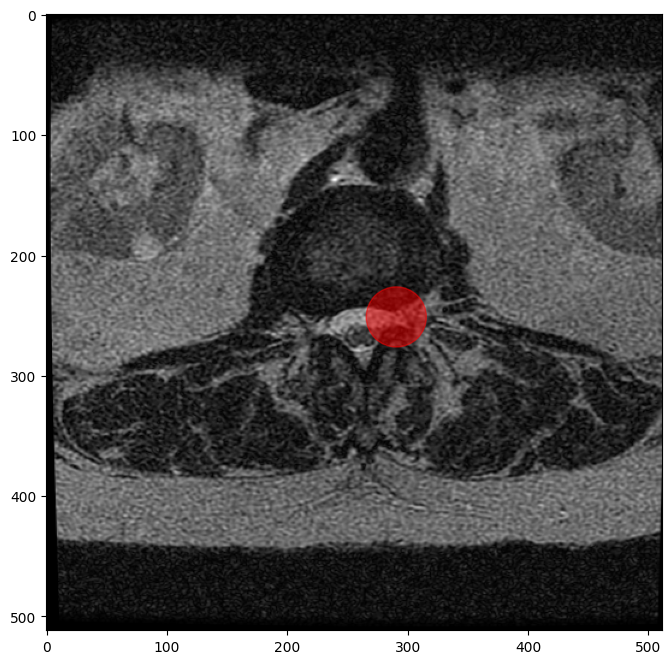

study_id                              11943292
series_id                            403244853
instance_number                              7
condition          Right Subarticular Stenosis
level                                    L1/L2
x                                   146.690265
y                                   163.256637
Name: 150, dtype: object


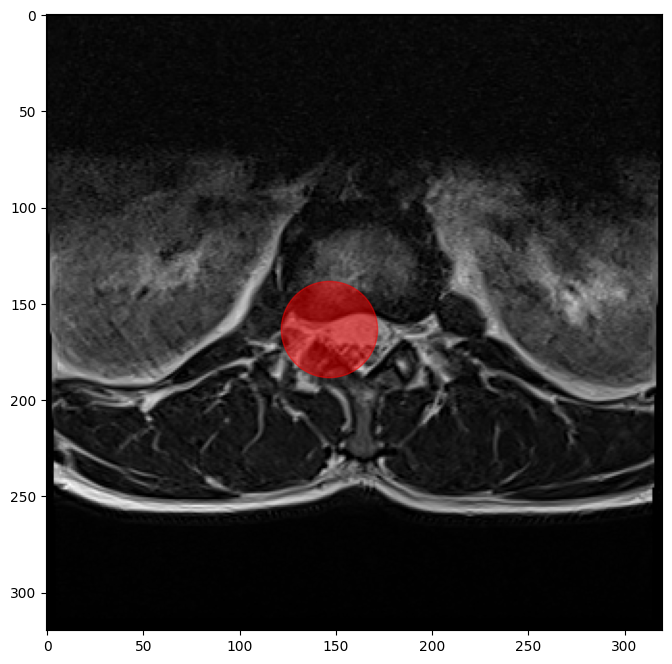

study_id                                   22191399
series_id                                 434280813
instance_number                                   5
condition          Right Neural Foraminal Narrowing
level                                         L5/S1
x                                        288.983914
y                                        308.600455
Name: 200, dtype: object


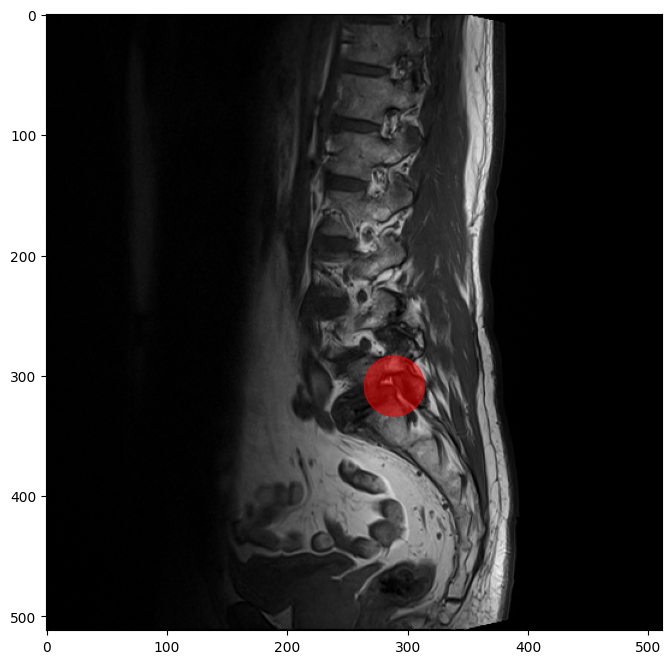

study_id                             29931867
series_id                           231278500
instance_number                             6
condition          Left Subarticular Stenosis
level                                   L2/L3
x                                  212.749658
y                                  206.445964
Name: 250, dtype: object


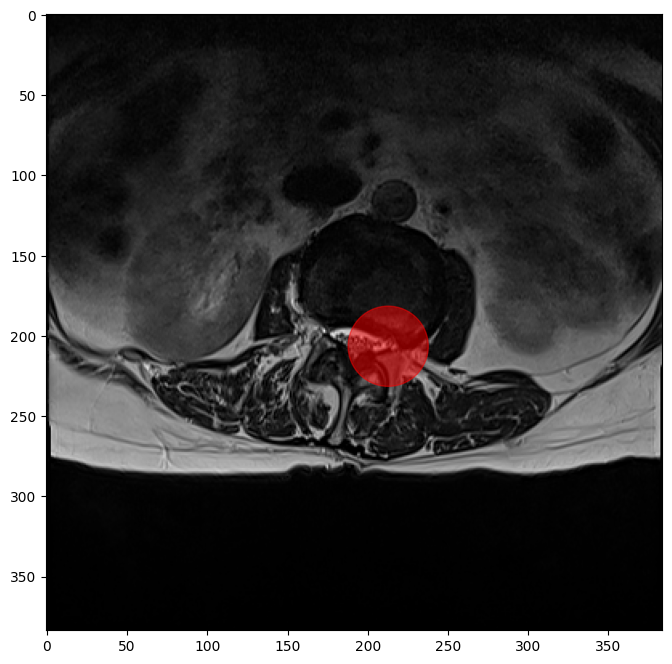

study_id                        38281420
series_id                      880361156
instance_number                        9
condition          Spinal Canal Stenosis
level                              L1/L2
x                             201.911765
y                              69.705882
Name: 300, dtype: object


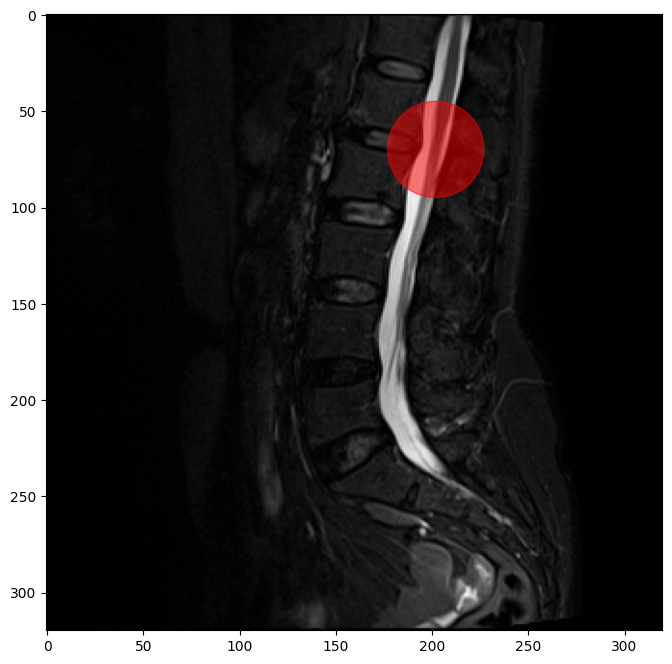

study_id                        41477684
series_id                     2595734107
instance_number                        9
condition          Spinal Canal Stenosis
level                              L1/L2
x                             338.994329
y                             123.160681
Name: 350, dtype: object


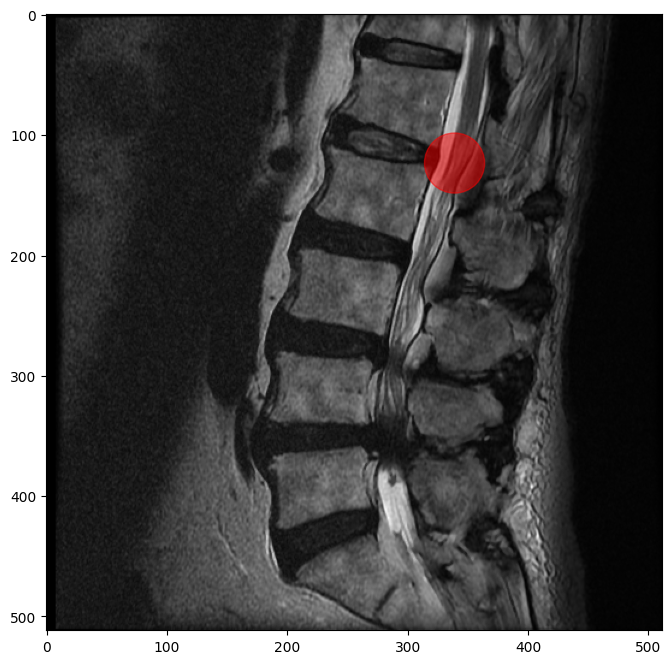

study_id                             46494080
series_id                          1543341132
instance_number                             3
condition          Left Subarticular Stenosis
level                                   L3/L4
x                                  278.116983
y                                  259.731778
Name: 400, dtype: object


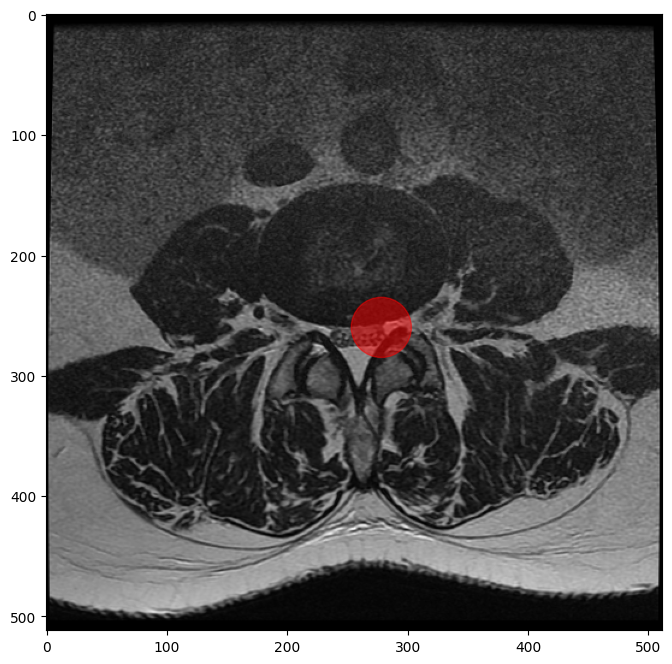

study_id                        52695609
series_id                       32135551
instance_number                       11
condition          Spinal Canal Stenosis
level                              L5/S1
x                             216.433213
y                             294.064982
Name: 450, dtype: object


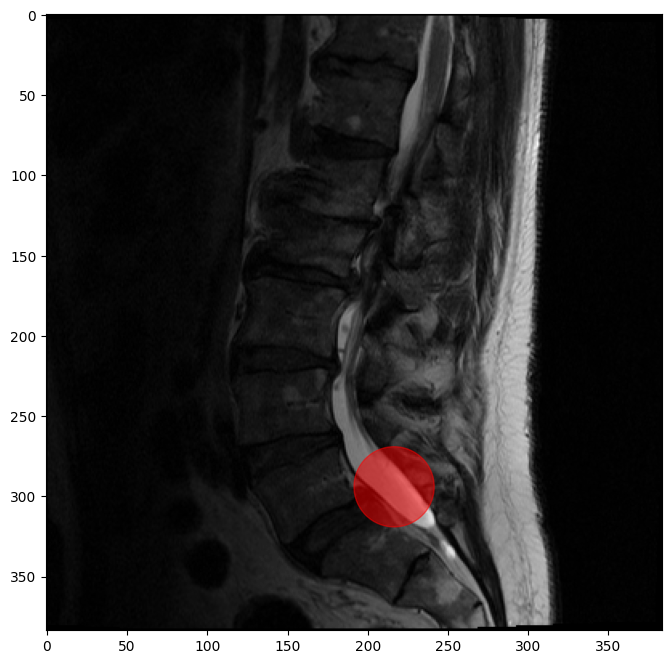

study_id                             58813022
series_id                           302608236
instance_number                            27
condition          Left Subarticular Stenosis
level                                   L3/L4
x                                  152.190789
y                                  147.536842
Name: 500, dtype: object


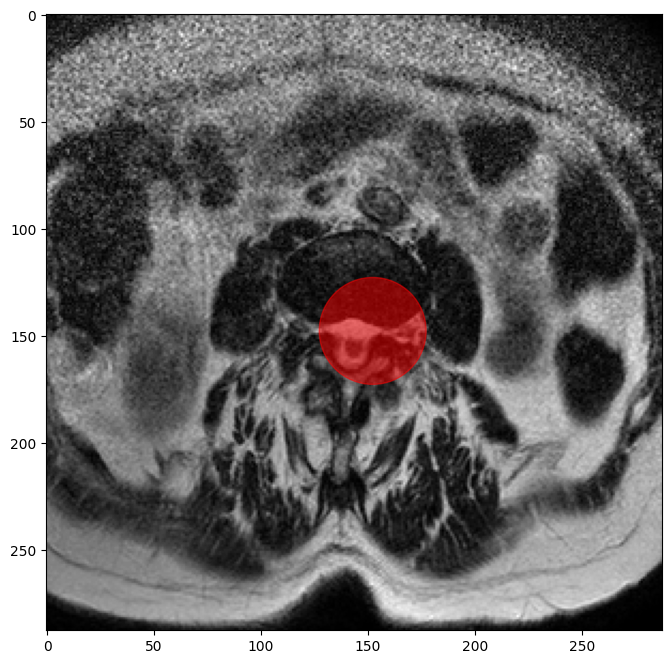

study_id                                   60612428
series_id                                 661972121
instance_number                                   5
condition          Right Neural Foraminal Narrowing
level                                         L5/S1
x                                        242.006956
y                                        260.305407
Name: 550, dtype: object


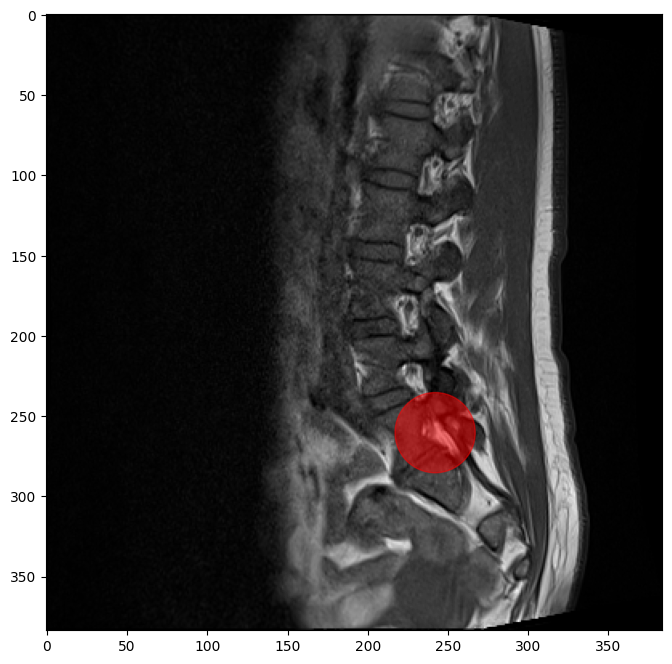

study_id                        64092030
series_id                     1233796867
instance_number                        8
condition          Spinal Canal Stenosis
level                              L5/S1
x                             275.309775
y                             402.042862
Name: 600, dtype: object


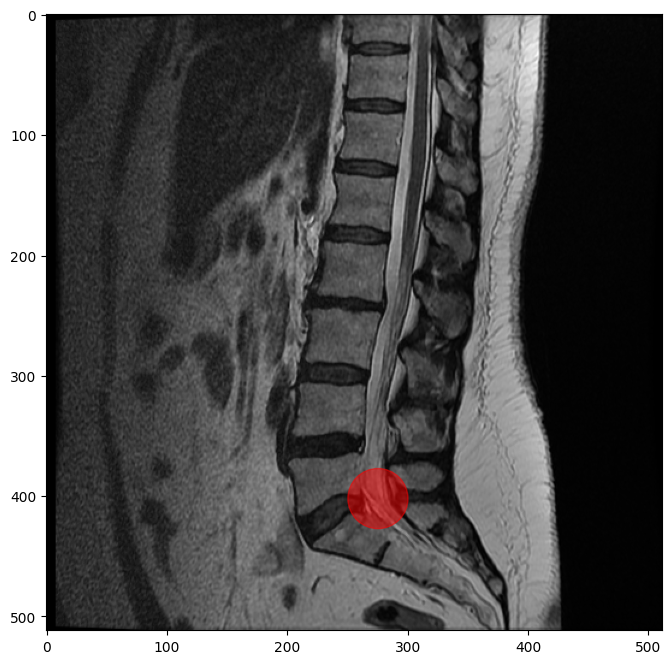

study_id                                  70878995
series_id                               2807935482
instance_number                                 11
condition          Left Neural Foraminal Narrowing
level                                        L4/L5
x                                       255.718681
y                                       323.235165
Name: 650, dtype: object


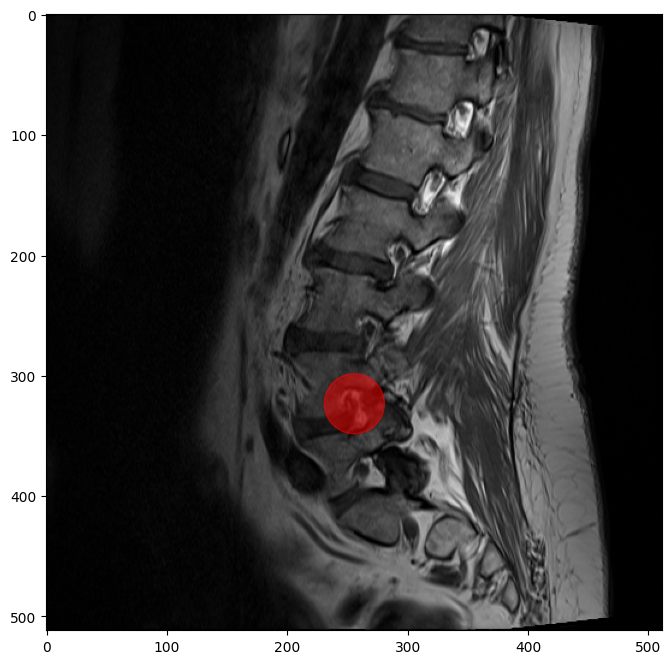

study_id                             73783367
series_id                          1885677897
instance_number                            35
condition          Left Subarticular Stenosis
level                                   L5/S1
x                                  253.100793
y                                  235.125708
Name: 700, dtype: object


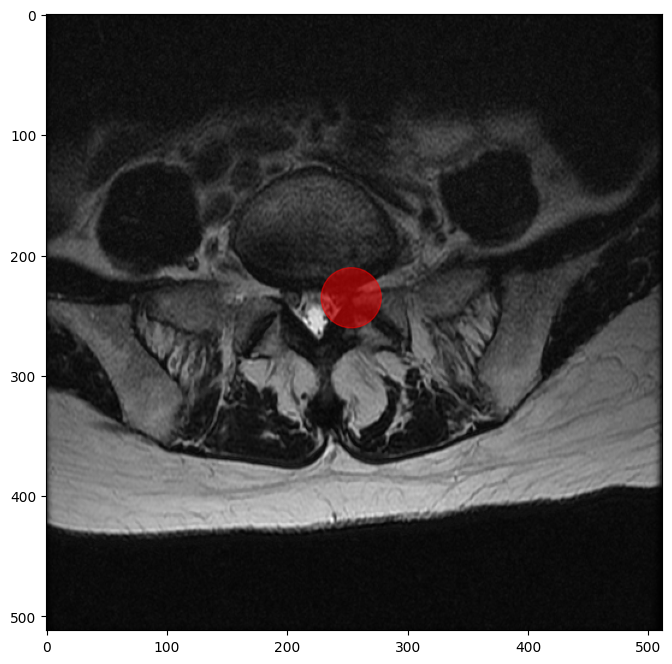

study_id                                   74782131
series_id                                2762032004
instance_number                                   8
condition          Right Neural Foraminal Narrowing
level                                         L3/L4
x                                        402.137097
y                                        354.987593
Name: 750, dtype: object


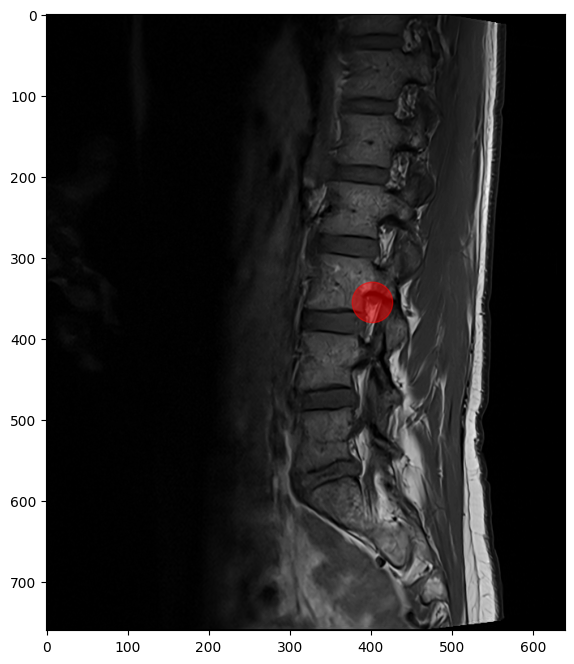

study_id                        76438935
series_id                     3320474714
instance_number                        9
condition          Spinal Canal Stenosis
level                              L2/L3
x                             285.388606
y                              214.02836
Name: 800, dtype: object


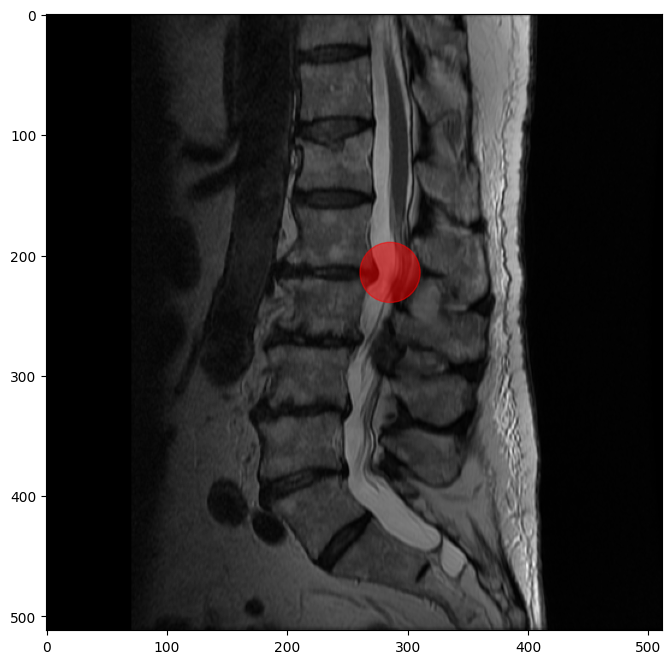

In [14]:
from matplotlib.patches import Circle

for row in [100,150,200,250,300,350,400,450,500,550,600,650,700,750,800]: 
    coords = train_label_coords.loc[row]
    study_id = coords.study_id
    ser_id = coords.series_id
    instance = coords.instance_number
    x = coords.x
    y = coords.y

    print(coords)
    # construct a filename to load
    file_name = f'{train_img_dir}/{study_id}/{ser_id}/{instance}.dcm'

    # load image and plot
    plt.figure(figsize=(8,8))
    ds = dicom.dcmread(file_name)
    plt.imshow(ds.pixel_array,cmap='gray')
    #plt.plot(x,y,marker='o',color='r',alpha=.5)
    plt.gca().add_artist(Circle(xy=(x, y), color='r',alpha=.5,radius=25))
    plt.show()

In [15]:
# so maybe put each labelled file into a separate folder.
# But need to know which vertebra it is.  So, need segmentation.
# or train on cropped image based on location

# Estimate means for initial submission

In [16]:
# test_rows = ss.row_id
# image_ids = []
# pred_types = []

# for row in test_rows:
#     img_id = row.split('_')[0]
#     image_ids.append(img_id)
#     pred_types.append(row[len(img_id)+1:])
    

In [17]:
# test_preds = []

# for row in pred_types:
#     test_preds.append(probs[row])
    
# test_preds = np.array(test_preds)

In [18]:
ss.normal_mild = .33
ss.moderate = .33
ss.severe = .33

# ss.head()

In [19]:
ss.to_csv('submission.csv',index=False)

# First, submit means of training data